<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regression: Predict gpus avg performance time in milliseconds.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

We are using the "SGEMM GPU kernel performance" dataset, which measures the running time of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds.
The results are then averaged and aggregated in one single final feature.
There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.
The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' (https://github.com/CNugteren/CLTune).
https://archive.ics.uci.edu/dataset/440/sgemm+gpu+kernel+performance

The models aim to predict the avg performance time.

#### Imports

In [ ]:
# Use seaborn for pairplot.
!pip install datasets

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

print(tf.__version__)

2.15.0


## Stesso modello che usiamo distribuito

### Get the data

In [99]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/gpus", download_mode="force_redownload")

Generating train split:   0%|          | 0/193280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/48320 [00:00<?, ? examples/s]

### Split training from test

In [113]:
training_set = pd.DataFrame(dataset['train'])
columns = list(dataset['train'].features.keys())
training_set = training_set.drop("Unnamed: 0", axis=1)

test_set = pd.DataFrame(dataset['test'])
test_set = test_set.drop("Unnamed: 0", axis=1)

### Split features from labels

In [114]:
train = training_set.copy()
test = test_set.copy()

train_labels = train.pop('avg_runs')
test_labels = test.pop('avg_runs')

## Build the model

In [132]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(4, activation='relu', input_shape=(14,)),
      #layers.Dense(16, activation='relu'),
      #layers.Dense(16, activation='relu'),
      layers.Dense(units=1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001), metrics=["mse", "mape", "mean_squared_logarithmic_error","cosine_similarity","logcosh", "R2Score"])
  return model

In [133]:
dnn_model = build_and_compile_model()
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 4)                 60        
                                                                 
 dense_37 (Dense)            (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### History

In [134]:
%%time
history = dnn_model.fit(
    train,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

CPU times: user 7min 40s, sys: 22.1 s, total: 8min 2s
Wall time: 8min 22s


In [135]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mape,mean_squared_logarithmic_error,cosine_similarity,logcosh,r2_score,val_loss,val_mse,val_mape,val_mean_squared_logarithmic_error,val_cosine_similarity,val_logcosh,val_r2_score,epoch
45,0.427177,1.393804,226.508621,0.054674,0.782582,0.242941,0.643441,0.425369,1.369272,208.156815,0.053798,0.785130,0.240155,0.643380,45
46,0.427121,1.394180,225.073318,0.054557,0.782957,0.243026,0.643347,0.425821,1.360523,206.522537,0.054163,0.783733,0.239613,0.645658,46
47,0.427192,1.391518,229.161133,0.054671,0.783216,0.242848,0.644027,0.427462,1.358160,206.448090,0.053144,0.783940,0.240551,0.646274,47
48,0.427129,1.396132,229.266663,0.054433,0.783397,0.243262,0.642846,0.428018,1.398947,212.097488,0.056708,0.777059,0.242398,0.635651,48
49,0.427190,1.395003,223.729172,0.054642,0.782983,0.242976,0.643136,0.425907,1.364205,210.179916,0.053485,0.783682,0.240346,0.644699,49


##Metrics insight


The **Mean Squared Logarithmic Error (MSLE)** is a statistical measure used to evaluate the accuracy of a forecasting model, particularly when the data has a wide range of values. It measures the average of the squared differences between the logarithms of the predicted and actual values.
The logarithmic transformation used in the MSLE reduces the impact of large differences between the actual and predicted values and provides a better measure of the relative errors between the two values. The MSLE is always a positive value, with a smaller MSLE indicating better forecast accuracy.
The MSLE is commonly used in applications where the data has a wide range of
values and the relative errors are more important than the absolute errors.
It is important to note that the MSLE is not suitable for data with negative values or zero values, as the logarithm function is not defined for these values. + Best possible score is 0.0, smaller value is better. Range = [0, +inf)

**Logcosh** works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect prediction.

**Cosine similarity** is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.
The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.
The cosine similarity captures the orientation (the angle) of the documents and not the magnitude.


In statistica, il **coefficiente di determinazione**, più comunemente **R2**, è un indice che misura il legame tra la variabilità dei dati e la correttezza del modello statistico utilizzato. Intuitivamente, esso è legato alla frazione della varianza non spiegata dal modello.

The **mean absolute percentage error (MAPE)**, also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio
Mean absolute percentage error is commonly used as a loss function for regression problems and in model evaluation, because of its very intuitive interpretation in terms of relative error.
From a practical point of view, the use of the MAPE as a quality function for regression model is equivalent to doing weighted mean absolute error (MAE) regression, also known as quantile regression.
Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application, and there are many studies on shortcomings and misleading results from MAPE.(vedi wiki)

In statistics, the **mean absolute scaled error (MASE)** is a measure of the accuracy of forecasts. It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast.
The mean absolute scaled error has favorable properties when compared to other methods for calculating forecast errors, such as root-mean-square-deviation, and is therefore recommended for determining comparative accuracy of forecasts.
The mean absolute scaled error can be easily interpreted, as values greater than one indicate that in-sample one-step forecasts from the naïve method perform better than the forecast values under consideration.

non presenti:

smape
mda
mad

In [68]:
dnn_model.metrics_names

['loss',
 'mse',
 'mape',
 'mean_squared_logarithmic_error',
 'cosine_similarity',
 'logcosh',
 'r2_score']

In [137]:
from ctypes import alignment
def plot_loss(history):
  fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(19, 5))
  ax1.plot(history.history['loss'], label='loss (mae)')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax2.plot(history.history['mse'], label='mse')
  ax2.plot(history.history['val_mse'], label='val_mse')
  ax3.plot(history.history['mape'], label='mape')
  ax3.plot(history.history['val_mape'], label='val_mape')
  ax4.plot(history.history['mean_squared_logarithmic_error'], label='mean_squared_logarithmic_error')
  ax4.plot(history.history['val_mean_squared_logarithmic_error'], label='val_mean_squared_logarithmic_error')
  ax5.plot(history.history['cosine_similarity'], label='cosine_similarity')
  ax5.plot(history.history['val_cosine_similarity'], label='val_cosine_similarity')
  ax6.plot(history.history['logcosh'], label='logcosh')
  ax6.plot(history.history['val_logcosh'], label='va_logcosh')
  ax7.plot(history.history['r2_score'], label='r2_score')
  ax7.plot(history.history['val_r2_score'], label='val_r2_score')

  ax1.set(xlabel='Epoch', ylabel='loss (mae)')
  ax1.legend(loc="upper right")
  ax1.grid(True)

  ax2.set(xlabel='Epoch', ylabel='mse')
  ax2.legend(loc="upper right")
  ax2.grid(True)

  ax3.set(xlabel='Epoch', ylabel='mape')
  ax3.legend(loc="upper right")
  ax3.grid(True)

  ax4.set(xlabel='Epoch', ylabel='mean_squared_logarithmic_error')
  ax4.legend(loc="upper right")
  ax4.grid(True)

  ax5.set(xlabel='Epoch', ylabel='cosine_similarity')
  ax5.legend(loc="upper right")
  ax5.grid(True)

  ax6.set(xlabel='Epoch', ylabel='logcosh')
  ax6.legend(loc="upper right")
  ax6.grid(True)

  ax7.set(xlabel='Epoch', ylabel='r2_score')
  ax7.legend(loc="upper right")
  ax7.grid(True)

  fig.tight_layout()

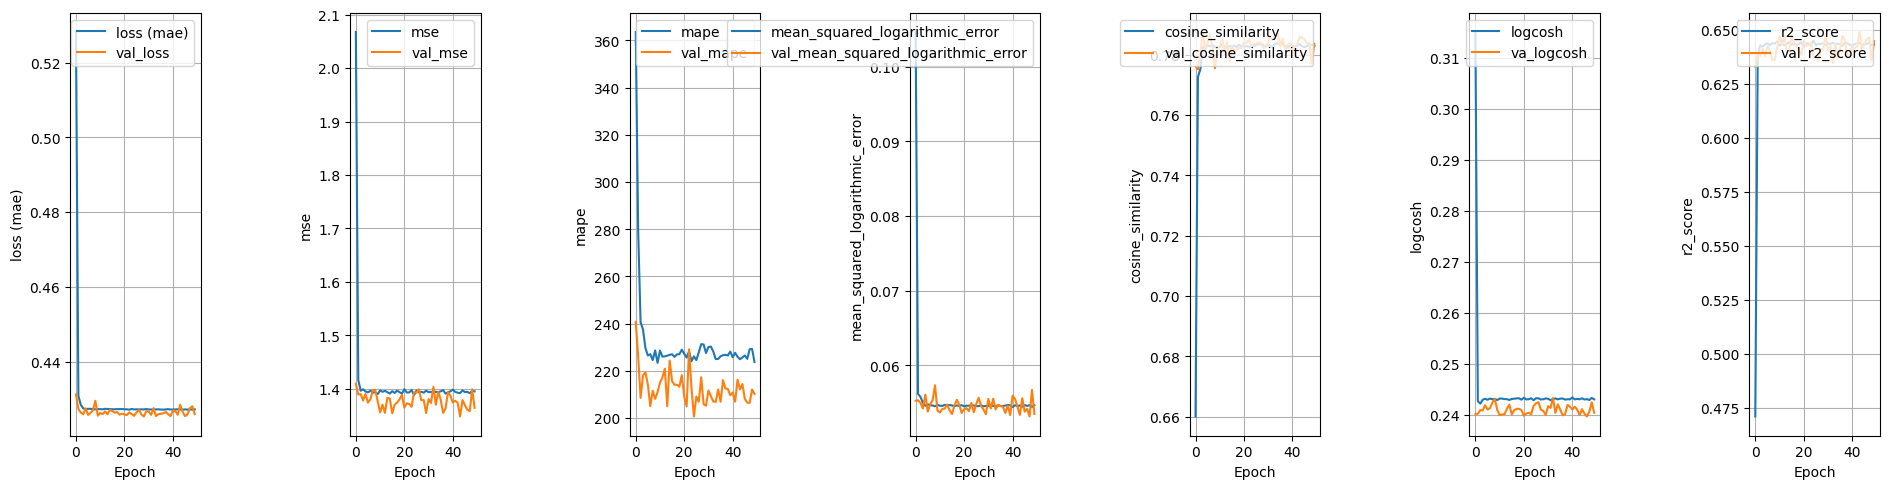

In [138]:
plot_loss(history)      # layers.Dense(4, activation='relu', input_shape=(14,)),

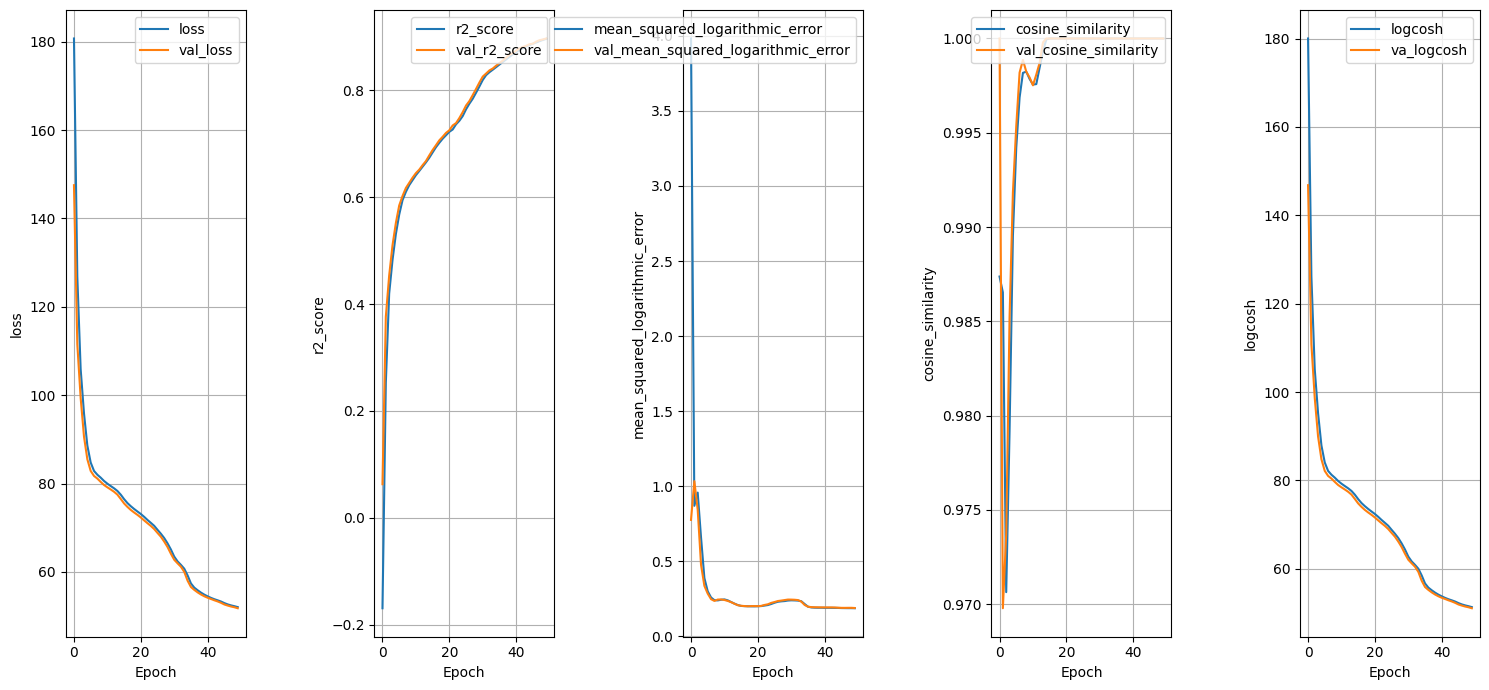

In [63]:
plot_loss(history) # hidden layer: Dense(4, activation='relu')

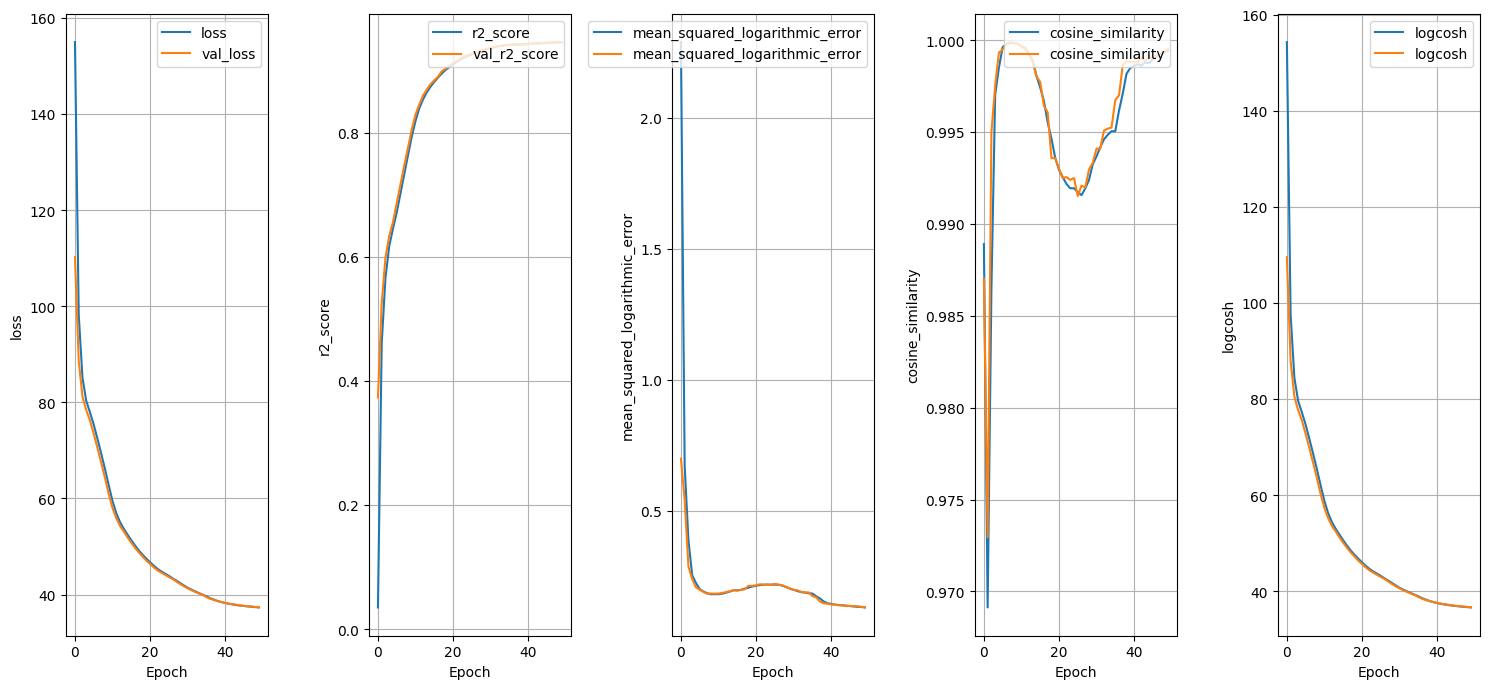

In [44]:
plot_loss(history) # hidden layer: Dense(256, activation='relu')

Collect the results on the test set:

In [47]:
loss, mse, mean_squared_logarithmic_error, cosine_similarity, logcosh, r2_score = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [48]:
test_results = {}

test_results['loss'] = loss
test_results['mae'] = mse
test_results['mean_squared_logarithmic_error'] = mean_squared_logarithmic_error
test_results['cosine_similarity'] = cosine_similarity
test_results['logcosh'] = logcosh
test_results['r2_score'] = r2_score

## Performance

Since all models have been trained, you can review their test set performance:

In [49]:
pd.DataFrame(test_results, index=['loss',
 'mse',
 'mean_squared_logarithmic_error',
 'cosine_similarity',
 'logcosh',
 'r2_score']).T

,loss,mse,mean_squared_logarithmic_error,cosine_similarity,logcosh,r2_score
loss,37.258915,37.258915,37.258915,37.258915,37.258915,37.258915
mae,7157.032227,7157.032227,7157.032227,7157.032227,7157.032227,7157.032227
mean_squared_logarithmic_error,0.127841,0.127841,0.127841,0.127841,0.127841,0.127841
cosine_similarity,0.999545,0.999545,0.999545,0.999545,0.999545,0.999545
logcosh,36.582100,36.582100,36.582100,36.582100,36.582100,36.582100
r2_score,0.947925,0.947925,0.947925,0.947925,0.947925,0.947925


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

1510/1510 [==============================] - 2s 1ms/step


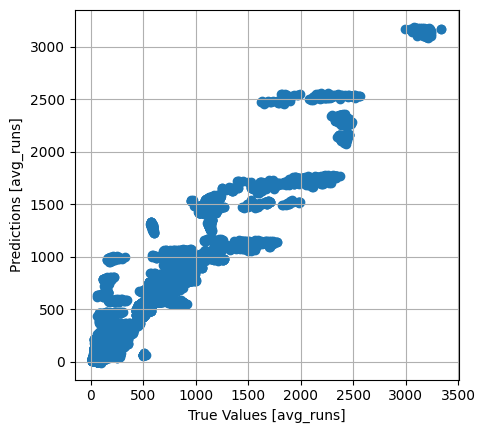

In [54]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [avg_runs]')
plt.ylabel('Predictions [avg_runs]')
plt.grid(True)

In [55]:
r = dnn_model.predict(test_features)
r

1510/1510 [==============================] - 2s 1ms/step


array([[ 48.413],
       [520.582],
       [ 36.978],
       ...,
       [839.557],
       [ 66.561],
       [ 64.295]], dtype=float32)

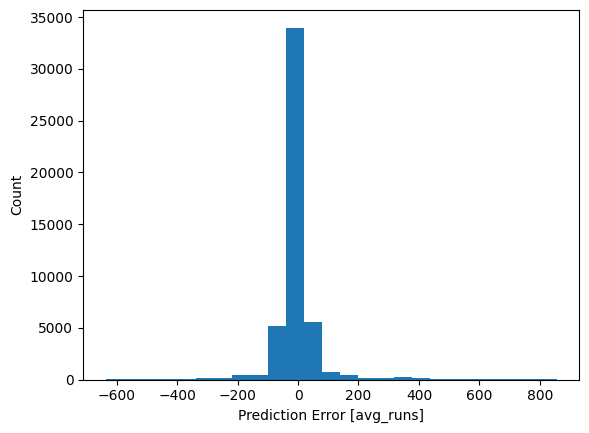

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [avg_runs]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
dnn_model.save('dnn_model.keras')

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [avg_runs]']).T

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.